LangChain RAG Tutotrial

Dependencies:

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


The application may contain multiple steps with multiple invocations of LLM calls. To inspect what exactly is going on inside your chain or agent is to use LangSmith.

Set environment variables to start logging traces:

In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Required to enable tracing
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"  # Optional (defaults to this)
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "RAG with LangChain"

In [3]:
from langchain_community.llms import Ollama

llm = Ollama(model="llama3")
response = llm.invoke("Hello, world!")
print(response)

C:\Users\krysp\AppData\Local\Temp\ipykernel_28696\226802051.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3")


Hello there! It's great to meet you! What brings you to this conversation today?


Select embeddings model:

In [4]:
%pip install -qU langchain-ollama

from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3")

Note: you may need to restart the kernel to use updated packages.


Select vector store:

In [5]:
%pip install -qU langchain-core

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

Note: you may need to restart the kernel to use updated packages.


# Indexing

### Loading documents
Blog post contents are loaded using DocumentLoaders, which return a list of Document objects.

In this specific case, WebBaseLoader allows to load HTML from web URLs. Only relevant HTML tags are keeped ("post-content", "post-title", "post-header").

In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

print(f"Total documents: {len(docs)}")
print(f"Total characters: {len(docs[0].page_content)}")

print(docs[0].page_content[:500])

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total documents: 1
Total characters: 43130


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Splitting documents

42k characters is too long to fit in the context window of most models. 
To handle this lets split the documents into chunks for embedding and vector storage using a RecursiveCharacterTextSplitter, which will recursively split the document using common separators like new lines until each chink is the appropriate size.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


### Storing documents

Now we have to index the 66 text chunks, by embedding each document split and inserting them into a vector store, that enable indexing and retrieving information based on vector representations (embeddings).

In [8]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['9c51fe16-2264-4255-b3a7-99ddc45c2d77', '49ef5b0a-f2a2-4ab6-a390-60e2a4546e90', 'c056159e-1cd3-49a6-ba0f-137543942dad']


# Retrieval and Generation

In [9]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll use LangGraph to tie together the retrieval and generation steps into a single application.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

### State

The state of the application controls what data is input to the application, transferred between steps and output by the application. It is typically a TypeDict.

For a simple RAG application, we can just keep track of input question, retrieved contexy and generated answer.

In [10]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Nodes (application steps)

A simple sequence of two steps is retrieval and generation.

In [14]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}

### Control flow

Compiles our application into a single graph object. In this case it means connecting retrieval and generation steps into a single sequence.

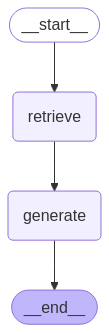

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Usage

In [16]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='f4b59d78-89f5-4061-a9b5-de4bb8190f2d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5929}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(id='69c240fe-a5a3-4ba4-897e-6c11cc2b1d2b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 21623}, page_content='This benchmark evaluates the agent’s tool use capabilities at three levels:\n\nLevel-1 evaluates the ability to call the API. Given an API’s description, the model needs to determine whether to call a given API, call it correctly, and respond properly to API returns.\nLevel-2 examines the ability to retrieve the API. The model needs to search for possible APIs that may solve the user’s requirement and learn how to use them by reading documentation.\nLevel-3 assesses the ability to plan AP

### Stream steps

In [17]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='f4b59d78-89f5-4061-a9b5-de4bb8190f2d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5929}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(id='69c240fe-a5a3-4ba4-897e-6c11cc2b1d2b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 21623}, page_content='This benchmark evaluates the agent’s tool use capabilities at three levels:\n\nLevel-1 evaluates the ability to call the API. Given an API’s description, the model needs to determine whether to call a given API, call it correctly, and respond properly to API returns.\nLevel-2 examines the ability to retrieve the API. The model needs to search for possible APIs that may solve the user’s requirement and learn how to use them by reading documentation.\nLevel-3 assesses the ab